# HW3 Seq2Seq

## Overview

In this homework, you will use the sequence-to-sequence (Seq2seq) autoencoder model to generate patient EHR embedding and use these embeddings to conduct unsupervised patient clustering.

---

In [1]:
import os
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)


# Define data path
DATA_PATH = "../HW3_Seq2Seq-lib/data"

---

## About Raw Data

We will use the same dataset synthesized from [MIMIC-III](https://mimic.physionet.org/gettingstarted/access/), but with different input formats.

The data has been preprocessed for you. Let us load them and take a look.

In [2]:
pids = pickle.load(open(os.path.join(DATA_PATH,'train/pids.pkl'), 'rb'))
vids = pickle.load(open(os.path.join(DATA_PATH,'train/vids.pkl'), 'rb'))
hfs = pickle.load(open(os.path.join(DATA_PATH,'train/hfs.pkl'), 'rb'))
seqs = pickle.load(open(os.path.join(DATA_PATH,'train/seqs.pkl'), 'rb'))
types = pickle.load(open(os.path.join(DATA_PATH,'train/types.pkl'), 'rb'))
rtypes = pickle.load(open(os.path.join(DATA_PATH,'train/rtypes.pkl'), 'rb'))

assert len(pids) == len(vids) == len(hfs) == len(seqs) == 1000
assert len(types) == 619

where

- `pids`: contains the patient ids
- `vids`: contains a list of visit ids for each patient
- `hfs`: contains the heart failure label (0: normal, 1: heart failure) for each patient
- `seqs`: contains a list of visit (in ICD9 codes) for each patient
- `types`: contains the map from ICD9 codes to ICD-9 labels
- `rtypes`: contains the map from ICD9 labels to ICD9 codes

Let us take a patient as an example.

In [3]:
# take the 3rd patient as an example

print("Patient ID:", pids[3])
print("Heart Failure:", hfs[3])
print("# of visits:", len(vids[3]))
for visit in range(len(vids[3])):
    print(f"\t{visit}-th visit id:", vids[3][visit])
    print(f"\t{visit}-th visit diagnosis labels:", seqs[3][visit])
    print(f"\t{visit}-th visit diagnosis codes:", [rtypes[label] for label in seqs[3][visit]])

Patient ID: 47537
Heart Failure: 0
# of visits: 2
	0-th visit id: 0
	0-th visit diagnosis labels: [12, 103, 262, 285, 290, 292, 359, 416, 39, 225, 275, 294, 326, 267, 93]
	0-th visit diagnosis codes: ['DIAG_041', 'DIAG_276', 'DIAG_518', 'DIAG_560', 'DIAG_567', 'DIAG_569', 'DIAG_707', 'DIAG_785', 'DIAG_155', 'DIAG_456', 'DIAG_537', 'DIAG_571', 'DIAG_608', 'DIAG_529', 'DIAG_263']
	1-th visit id: 1
	1-th visit diagnosis labels: [12, 103, 240, 262, 290, 292, 319, 359, 510, 513, 577, 307, 8, 280, 18, 131]
	1-th visit diagnosis codes: ['DIAG_041', 'DIAG_276', 'DIAG_482', 'DIAG_518', 'DIAG_567', 'DIAG_569', 'DIAG_599', 'DIAG_707', 'DIAG_995', 'DIAG_998', 'DIAG_V09', 'DIAG_584', 'DIAG_031', 'DIAG_553', 'DIAG_070', 'DIAG_305']


Note that `seqs` is a list of list of list. That is, `seqs[i][j][k]` gives you the k-th diagnosis codes for the j-th visit for the i-th patient.

And you can look up the meaning of the ICD9 code online. For example, `DIAG_276` represetns *disorders of fluid electrolyte and acid-base balance*.

Further, let see number of heart failure patients.

In [4]:
print("number of heart failure patients:", sum(hfs))
print("ratio of heart failure patients: %.2f" % (sum(hfs) / len(hfs)))

number of heart failure patients: 548
ratio of heart failure patients: 0.55


For the sake of computational efficiency, we will only use the diagnosis that appears more than or equal to 50 times in `seqs`. We need first store these frequent diagnosis labels into list `freq_codes`.

In [5]:
freq_codes = []

'''
Append all codes that appears more than 50 times in freq_codes list.
'''

cnt_dict = {}
for i in range(len(seqs)):
    for j in range(len(seqs[i])):
        for each_code in seqs[i][j]:
            if each_code not in cnt_dict:
                cnt_dict[each_code] = 1
            else:
                cnt_dict[each_code] += 1

for each_code in cnt_dict:
    if cnt_dict[each_code] >= 50:
        freq_codes.append(each_code)
        
assert len(freq_codes) == 105

In [6]:
code2idx = {code: idx for idx, code in enumerate(freq_codes)}

In [7]:
k = 1009
code2idx[k] if k in code2idx else -1

-1

## 2 Build the dataset [20 points]

### 2.1 Custom the dataset  [5 points]

First, let us implement a custom dataset using PyTorch class `Dataset`, which will characterize the key features of the dataset we want to generate.

We will use the sequences of diagnosis codes `seqs` as input and heart failure `hfs` as output.

In [8]:
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    
    def __init__(self, seqs, hfs):
        
        """
        TODO: Store `seqs`. to `self.x` and `hfs` to `self.y`.
        
        Note that you DO NOT need to covert them to tensor as we will do this later.
        Do NOT permute the data.
        """
        
        # your code here
        # raise NotImplementedError
        self.x = seqs
        self.y = hfs
    
    def __len__(self):
        
        """
        TODO: Return the number of samples (i.e. patients).
        """
        
        # your code here
        # raise NotImplementedError
        return len(self.x)
    
    def __getitem__(self, index):
        
        """
        TODO: Generates one sample of data.
        
        Note that you DO NOT need to covert them to tensor as we will do this later.
        """
        
        # your code here
        # raise NotImplementedError
        return self.x[index], self.y[index]

dataset = CustomDataset(seqs, hfs)

In [9]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

dataset = CustomDataset(seqs, hfs)
assert len(dataset) == 1000



### 2.2 Collate Function [10 points]

As you note that, we do not convert the data to tensor in the built `CustomDataset`. Instead, we will do this using a collate function `collate_fn()`. 

This collate function `collate_fn()` will be called by `DataLoader` after fetching a list of samples using the indices from `CustomDataset` to collate the list of samples into batches.

For example, assume the `DataLoader` gets a list of two samples.

```
[ [ [0, 1, 2], [4, 0] ], 
  [ [2, 3], [1], [1, 4] ] ]
```

where the first sample has two visits `[0, 1, 2]` and `[4, 0]` and the second sample has three visits `[2, 3]`, `[1]`, and `[4, 1]`.

The collate function `collate_fn()` is supposed to pad them into a multi-hot vector with shape (2, 3, 5), where 3 is the maximum number of visits, and 5 is the number of total diagnosis codes.

``` 
[ [ [1, 1, 1, 0, 0], [1, 0, 0, 0, 1], [0, 0, 0, 0, 0] ],
  [ [0, 0, 1, 1, 0], [0, 1, 0, 0, 0], [0, 1, 0, 0, 1] ] ]
```

Further, the padding information will be stored in a mask with the shape (2, 3), where 1 indicates that the visit at this position is from the original input, and 0 indicates that the visit at this position is the padded value.

```
[ [1, 1, 0], 
  [1, 1, 1] ]
```

We need to pad the sequences into the same length so that we can do batch training on GPU. And we also need this mask so that when training, we can ignored the padded value as they actually do not contain any information.

We only keep the codes that in the `freq_codes` list and drop other codes.

In [10]:
def collate_fn(data):
    """
    Collate the the list of samples into batches. For each patient, you need to pad the diagnosis
        sequences to the sample shape (max # visits, len(freq_codes)). The padding infomation
        is stored in `mask`.
    
    Arguments:
        data: a list of samples fetched from `CustomDataset`
        
    Outputs:
        x: a tensor of shape (# patiens, max # visits, len(freq_codes)) of type torch.float
        masks: a tensor of shape (# patiens, max # visits) of type torch.bool
        y: a tensor of shape (# patiens) of type torch.float
        
    Note that you can obtains the list of diagnosis codes and the list of hf labels
        using: `sequences, labels = zip(*data)`
    """

    sequences, labels = zip(*data)

    y = torch.tensor(labels, dtype=torch.float)
    
    num_patients = len(sequences)
    num_visits = [len(patient) for patient in sequences]
    max_num_visits = max(num_visits)
    
    x = torch.zeros((num_patients, max_num_visits, len(freq_codes)), dtype=torch.float)   
    masks = torch.zeros((num_patients, max_num_visits), dtype=torch.bool)
    for i_patient, patient in enumerate(sequences):
        for j_visit, visit in enumerate(patient):
            visit_ones = torch.tensor(np.ones_like(visit))
            masks[i_patient] = F.pad(visit_ones, (0, max_num_visits - len(visit)), mode='constant', value=0)
            for code in visit:
                """
                TODO: 1. check if code is in freq_codes;
                      2. obtain the code index using code2idx;
                      3. set the correspoindg element in x to 1.
                """
                # your code here
                # raise NotImplementedError
                if code in code2idx:
                    x[i_patient][j_visit][code2idx[code]] = 1
    
    masks = torch.sum(x, dim=-1) > 0
    
    return x, masks, y

In [11]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=10, collate_fn=collate_fn)
loader_iter = iter(loader)
x, masks, y = next(loader_iter)

assert x.dtype == torch.float
assert y.dtype == torch.float
assert masks.dtype == torch.bool

assert x.shape == (10, 3, 105)
assert y.shape == (10,)
assert masks.shape == (10, 3)

assert x[0][0].sum() == 9
assert masks[0].sum() == 2



Now we have `CustomDataset` and `collate_fn()`. Let us split the dataset into training and validation sets.

In [12]:
from torch.utils.data.dataset import random_split

split = int(len(dataset)*0.8)

lengths = [split, len(dataset) - split]
train_dataset, val_dataset = random_split(dataset, lengths)

print("Length of train dataset:", len(train_dataset))
print("Length of val dataset:", len(val_dataset))

Length of train dataset: 800
Length of val dataset: 200


### 2.3 DataLoader [5 points]

Now, we can load the dataset into the data loader.

In [13]:
from torch.utils.data import DataLoader

def load_data(train_dataset, val_dataset, collate_fn):
    
    '''
    TODO: Implement this function to return the data loader for  train and validation dataset. 
    Set batchsize to 32. Set `shuffle=True` only for train dataloader.
    
    Arguments:
        train dataset: train dataset of type `CustomDataset`
        val dataset: validation dataset of type `CustomDataset`
        collate_fn: collate function
        
    Outputs:
        train_loader, val_loader: train and validation dataloaders
    
    Note that you need to pass the collate function to the data loader `collate_fn()`.
    '''
    
    # your code here
    # raise NotImplementedError
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)
    
    return train_loader, val_loader

In [14]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

train_loader, val_loader = load_data(train_dataset, val_dataset, collate_fn)
assert len(train_loader) == 25, "Length of train_loader should be 25, instead we got %d"%(len(train_loader))



## 3 Building the Seq2Seq model [50 points]

The most common sequence-to-sequence (Seq2Seq) models are *encoder-decoder* models, which commonly use a *recurrent neural network* (RNN) to *encode* the source (input) sentence into a single vector. In this notebook, we'll refer to this single vector as a *context vector*. Since we have implemented RNNs in the previous homework, we will instead use a CNN as the encoder. We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* to output the target by generating it one word at a time.

In this question, we will build a naive Seq2Seq autoencoder model which uses a CNN with attention mechanism as encoder and a GRU as decoder. The input to the encoder will be the multi-hot code vector at each timestep. The decoder will try to reconstruct the input at each timestep based on the hidden embedding of the encoder network. In this way, we can store the longitudinal patient EHR data in a vector (i.e., the hidden state of the encoder network).

### 3.1 Build the encoder model [15 points]

First, we will build the encoder model using ```nn.Conv2d```. We will 1) feed the input into the CNN and calculate a hidden state for each timestep, 2) calculate the attention weights for each timestep, 3) calculate the context vector by aggregating all the hidden states using the attention weights. Importantly, you need to use `masks` to mask out the visits when you calculate the attention weights and aggregate the hidden states.

In [23]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        """
        TODO:
            1. Define the CNN using `nn.Conv2d()`.
               The input channel is 1. Set the output channel to 128.
               Set kernel size to (3, 105). Set padding to (1,0).
            2. Define the attention layer using `nn.Linear`.
        """
        self.cnn = None
        self.att = None
        # your code here
        # raise NotImplementedError
        self.cnn = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size = (3, 105), padding = (1, 0))
        self.att = nn.Linear(in_features = 128, out_features = 1)
    
    def forward(self, x, masks):
        """
        TODO:
            1. Pass the sequence through the CNN layer and get hidden states.
               You may need to add an extra dimension at dim=1.
            2. Permute and squeeze the hidden states, so that the shape is (batch_size, # visits, 128)
            3. Calculate the attention score using `self.att`
            4. Mask out the padded visits in the attention score with -1e9.
            5. Perform softmax on the attention score to get the attention value.
            6. Calculate the context vector using attention value and hidden states.
            
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # visits, # diagnosis codes)
            masks: the padding masks of shape (batch_size, # visits)

        Outputs:
            states: context vectors of shape (batch_size, 128)
        """
        # your code here
        # raise NotImplementedError
        # print(f"1 Original. {x.size()}")
        
        print(x[0])
        x1 = torch.unsqueeze(x, dim=1)
        print(f"1.1 unsqueeze. {x1.size()}")
        
        h = self.cnn(x1)
        print(f"2 conv1. {h.size()}")
        print(h)
        
        p = h.permute(0, 2, 1, 3)
        print(f"3 permute. {p.size()}")
        
        ps = torch.squeeze(p, dim = 3)
        print(f"4 squeeze hidden. {ps.size()}")
        
        a = self.att(ps)
        print(f"5 att. {a.size()}")
        print(a)
        
        print(f"5 masks. {masks.size()}")
        
        m = ~torch.unsqueeze(masks, dim = 2)
        a = a.masked_fill_(m, -1e9)
        print(f"6 att after mask. {a.size()}")
        
        smax0 = nn.Softmax(dim = 1)
        smax_out = smax0(a)
        print(f"7 smax_0: att value. {smax_out.shape}")
        print(smax_out)
        
        # print("-----")
        
        # print(ps)
        # print(smax_out)
        
        context = torch.sum(ps * smax_out, dim = 1)
        
        # context = torch.matmul(ps, smax_out)
        # print(f"8 context. {context.shape}")
        # print(context)
        
        return context
        

In [24]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

torch.manual_seed(42)

encoder = Encoder()

layer_types_to_check = [nn.Conv2d, nn.Linear]

for layer_type in layer_types_to_check:
    no_layer = True
    for child in encoder.children():
        for layer in child.modules():
            if(isinstance(layer, layer_type)):
                no_layer = False
    assert no_layer is False

loader = DataLoader(dataset, batch_size=10, collate_fn=collate_fn)
loader_iter = iter(loader)
x, masks, y = next(loader_iter)
assert encoder(x, masks).shape == (10, 128), "output shape is not (batch_size, 128)!"
assert round(encoder(x, masks)[0][0].item(), 4) == -0.1248, "output value is wrong!"



tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### 3.2 Build the decoder model [15 points]

Next, we'll build our decoder, which will be a GRU.

The `Decoder` class does a single step of decoding, i.e. it ouputs single reconstructed results per time-step. The GRU layer will receive the initial hidden state from the encoder outputs. The first input to the decoder will be a zero vector, and then the decoder will try to reconstruct the input at timestep 1. For the following timestep, the input will be the output of the decoder from last timestep.

Within the `forward` method, we accept a batch of inputs and previous hidden states. As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. We `unsqueeze` the inputs to add a length dimension of 1.

In [17]:
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        """
        TODO: Define the RNN using `nn.GRU()`; 
              The `input_size` is 105. Set `hidden_size` to 128. Set `batch_first` to True.
        """
        self.rnn = None
        # your code here
        # raise NotImplementedError
        self.rnn = nn.GRU(input_size = 105, hidden_size = 128, batch_first = True)
        
        self.linear1 = nn.Linear(128, 128)
        self.act = nn.ReLU()
        self.linear2 = nn.Linear(128, 105)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, hiddens):
        """
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # diagnosis codes)
            hiddens: the padding masks of shape (batch_size, 128)

        Outputs:
            preds: the reconstructed results of shape (batch_size, # diagnosis codes)
            hiddens: the hidden state of the GRU with shape (batch_size, 128)
        """
        
        # Unsqueeze the input at dimension 1 -> (batch_size, 1, # diagnosis codes)
        x = x.unsqueeze(1)
        # Unsqueeze the hiddens at dimension 0; -> (1, batch_size, 128)
        hiddens = hiddens.unsqueeze(0)
        
        """
        TODO:
            1. Pass the input through the RNN layer; Remember to set the initial hidden states of GRU `h_0` to `hiddens`
            2. Squeeze the hidden states h_n of RNN at dimension 0.
        """
        h_n = None
        # your code here
        # raise NotImplementedError
        output, h_n = self.rnn(x, hiddens)
        h_n = h_n.squeeze(0)
        
        preds = self.linear1(h_n)
        preds = self.act(preds)
        preds = self.linear2(preds)
        preds = self.sigmoid(preds)
        
        return preds, h_n

In [18]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

torch.manual_seed(42)

decoder = Decoder()

layer_types_to_check = [nn.GRU, nn.Linear, nn.Sigmoid]

for layer_type in layer_types_to_check:
    no_layer = True
    for child in decoder.children():
        for layer in child.modules():
            if(isinstance(layer, layer_type)):
                no_layer = False
    assert no_layer is False

x = torch.randn(10, 105)
hiddens = torch.randn(10, 128)
assert decoder(x, hiddens)[0].shape == (10, 105), "preds is not of shape (batch_size, 105)!"
assert decoder(x, hiddens)[1].shape == (10, 128), "h_n is not of shape (batch_size, 128)!"
assert round(decoder(x, hiddens)[0][0][0].item(), 4) == 0.4646, "preds value is wrong!"
assert round(decoder(x, hiddens)[1][0][0].item(), 4) == 0.9358, "h_n value is wrong!"



### 3.3 Connect the encoder and decoder [20 points]

For the final part of the implemenetation, we'll implement the Seq2Seq model

The `Seq2Seq` model takes in an `Encoder` and a `Decoder`.

Our `forward` method takes the source sequence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth input in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the output that the model predicted as the next input to the model.  

The first input to the decoder is a zero vector.

During each iteration of the loop, we:
- pass the input, previous hidden states into the decoder
- receive a prediction and next hidden state from the decoder
- decide if we are going to "teacher force" or not
    - if we do, the next `input` is the ground-truth input in the sequence
    - if we don't, the next `input` is the predicted input in the sequence
    
Once we've made all of our predictions, we return our tensor full of predictions.

For example, So our `inputs` and `outputs` of the decoder look something like ($x_t$ is the orinal input, $\hat{x}_t$ is the reconstructed input):

If not use teach force:

$$\begin{align*}
\text{inputs} &= [0, \hat{x}_1, \hat{x}_2]\\
\text{outputs} &= [\hat{x}_1, \hat{x}_2, \hat{x}_3]
\end{align*}$$

If use teach force:

$$\begin{align*}
\text{inputs} &= [0, x_1, x_2]\\
\text{outputs} &= [\hat{x}_1, \hat{x}_2, \hat{x}_3]
\end{align*}$$

In [19]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder, decoder, teacher_forcing_ratio):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.teacher_forcing_ratio = teacher_forcing_ratio
        
    def forward(self, x, masks):
        
        """
        STEP:
            1. Pass the input through the encoder; save the output to `hidden`;
            2. Pass the first input (0) and encoder hidden state to the decoder;
            3. Use for-loop to 
                   1. Use `random.random()` to decide whether to use teacher force
                   2. Pass the previous output `cur_pred` / the ground truth input `x[:, t-1, :]` 
                      and previous hidden state `h` to the decoder;
                   3. Save `cur_pred`, the output of the decoder, to a list.
            4. Use torch.stack to convert the list to a tensor and 
               reshape it to (batch_size, # visits, # diagnosis codes)
            
        Arguments:
            x: the diagnosis sequence of shape (batch_size, # visits, # diagnosis codes)
            masks: the padding masks of shape (batch_size, # visits)

        Outputs:
            preds: the reconstructed results of shape (batch_size, # visits, # diagnosis codes)
        """
        
        preds = []
        
        batch_size = x.shape[0]
        seq_len = x.shape[1]
        
        """
        TODO: perform step 1
        """
        hidden = None
        # your code here
        # raise NotImplementedError
        
        # 1. my code
        hidden = self.encoder(x, masks)
        
        # step 2
        x_decode = torch.zeros(batch_size, 105)
        cur_pred, h = self.decoder(x_decode, hidden)
        preds.append(cur_pred)
        
        for t in range(1, seq_len):
            # step 3.1
            teacher_force = random.random() < self.teacher_forcing_ratio
            
            """
            TODO: perform step 3.2
            """
            # your code here
            # raise NotImplementedError
            
            # 2. my code.
            if (teacher_force == True):
                cur_pred, h = self.decoder(x[:, t-1, :], h)
            else:
                cur_pred, h = self.decoder(cur_pred, h)
            
            # step 3.3
            preds.append(cur_pred)
        
        # step 4
        return torch.stack(preds).permute(1,0,2)

In [20]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''


torch.manual_seed(42)
random.seed(42)

seq2seq = Seq2Seq(encoder, decoder, 0.5)

layer_types_to_check = [nn.GRU, nn.Linear, nn.Sigmoid]

for layer_type in layer_types_to_check:
    no_layer = True
    for child in seq2seq.children():
        for layer in child.modules():
            if(isinstance(layer, layer_type)):
                no_layer = False
    assert no_layer is False

x = torch.randn(10, 5, 105)
masks = torch.ones(10, 5, dtype=torch.bool)
assert seq2seq(x, masks).shape == (10, 5, 105), "output shape should be (batch_size, # visits, # diagnosis codes)!"
assert round(seq2seq(x, masks)[0][0][0].item(), 4) == 0.4819, "output value is wrong!"



## 4 Model training [15 points]

### 4.1 Loss and optimizer
Because we are reconstructing original input, we use BCELoss as loss function. 

In [21]:
# set reduction='none' because we need to mask out the padding values manually.
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-2)

### 4.2 Evaluate

In [22]:
from sklearn.metrics import f1_score, accuracy_score


def eval(model, val_loader):
    
    """
    Evaluate the model.
    
    Arguments:
        model: the seq2seq model
        val_loader: validation dataloader
        
    Outputs:
        f1: overall f1 score
        accuracy: overall accuracy score; 
        use np.round to round the preds to calculate the metrics.
        
    We have implement this for you.
    """
    
    model.eval()

    x_pred = []
    x_true = []
    for x, masks, y in val_loader:
        x_hat = model(x, masks).detach().numpy()
        x_hat = np.round(x_hat)
        for i in range(len(x_hat)):
            for j in range(len(x_hat[i])):
                if masks[i, j] == 1:
                    x_pred.append(x_hat[i,j])
                    x_true.append(x.numpy()[i,j])
    
    f = f1_score(y_pred=x_pred, y_true=x_true, average='micro')
    acc = accuracy_score(y_pred=x_pred, y_true=x_true)
    return f, acc

### 4.3 Training

In [23]:
def train(model, train_loader, val_loader, n_epochs):
    """
    Train the model.
    
    Arguments:
        model: the RNN model
        train_loader: training dataloder
        val_loader: validation dataloader
        n_epochs: total number of epochs
        
    We have implement this for you.
    """

    for epoch in range(n_epochs):
        seq2seq.train()
        train_loss = 0
        for x, masks, y in train_loader:
            optimizer.zero_grad()
            x_hat = seq2seq(x, masks)
            loss = criterion(x_hat, x)
            loss = loss * masks.float().unsqueeze(-1)
            loss = torch.mean(torch.sum(loss, dim=[1,2]))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print('Epoch: {} \t Training Loss: {:.6f}'.format(epoch+1, train_loss))
        f, acc = eval(model, val_loader)
        print('Epoch: %d \t Validation f: %.2f, acc: %.2f'%(epoch+1, f, acc))

    
# number of epochs to train the model
n_epochs = 100

train(seq2seq, train_loader, val_loader, n_epochs)

Epoch: 1 	 Training Loss: 78.112184
Epoch: 1 	 Validation f: 0.10, acc: 0.00
Epoch: 2 	 Training Loss: 57.556242
Epoch: 2 	 Validation f: 0.32, acc: 0.00
Epoch: 3 	 Training Loss: 50.496551
Epoch: 3 	 Validation f: 0.38, acc: 0.00
Epoch: 4 	 Training Loss: 46.157900
Epoch: 4 	 Validation f: 0.44, acc: 0.00
Epoch: 5 	 Training Loss: 42.832715
Epoch: 5 	 Validation f: 0.50, acc: 0.02
Epoch: 6 	 Training Loss: 39.707898
Epoch: 6 	 Validation f: 0.54, acc: 0.02
Epoch: 7 	 Training Loss: 37.138490
Epoch: 7 	 Validation f: 0.55, acc: 0.02
Epoch: 8 	 Training Loss: 34.899476
Epoch: 8 	 Validation f: 0.59, acc: 0.02
Epoch: 9 	 Training Loss: 33.019463
Epoch: 9 	 Validation f: 0.60, acc: 0.03
Epoch: 10 	 Training Loss: 30.988717
Epoch: 10 	 Validation f: 0.62, acc: 0.03
Epoch: 11 	 Training Loss: 28.891745
Epoch: 11 	 Validation f: 0.62, acc: 0.04
Epoch: 12 	 Training Loss: 27.186029
Epoch: 12 	 Validation f: 0.63, acc: 0.05
Epoch: 13 	 Training Loss: 25.654470
Epoch: 13 	 Validation f: 0.63, a

In [24]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''



'\nAUTOGRADER CELL. DO NOT MODIFY THIS.\n'

## 5 Unsupervised patient clustering [15 points]

After training a seq2seq model, we can use the encoder to generate patient embeddings. These embeddings can be used for unsupervised tasks.

In [25]:
def get_embeddings(model, data_loader):
    """
    Use trained encoder model to get patient embeddings.
    
    Arguments:
        model: trained seq2seq model
        data_loader: dataloder
        
    Return:
        embeddings: numpy array that contains patient embeddings.
        labels: numpy array that contains patient heart failure label.
    
    We have implement this for you.
    """
    
    seq2seq.eval()
    embeddings = []
    labels = []
    for x, masks, y in data_loader:
        cur_embd = seq2seq.encoder(x, masks)
        embeddings += list(cur_embd.detach().numpy())
        labels += list(y.numpy())
        
    return np.array(embeddings), np.array(labels)

    
embeddings, labels = get_embeddings(seq2seq, val_loader)

Next we will use KMeans algorithm to cluster these embeddings

In [26]:
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans

def get_clusters(embeddings):
    """
    TODO: 1. Use K-means to generate patient clusters. (set K to 2)
          2. Use calinski harabaz score to evaluate clustering results
    
    Arguments:
        embeddings: obtained patient embeddings
        
    Return:
        labels: K-means clustering labels
        
    Hint: Use sklearn.cluster.KMeans and sklearn.metrics.calinski_harabasz_score.
    
    """
    
    # your code here
    # raise NotImplementedError
    K = 2
    clusters = KMeans(n_clusters=K).fit(embeddings)
    score = calinski_harabasz_score(embeddings, clusters.labels_)
    return clusters.labels_
    
cluster_labels = get_clusters(embeddings)

In [27]:
'''
AUTOGRADER CELL. DO NOT MODIFY THIS.
'''

assert cluster_labels.shape == (200, )



Let us use T-SNE to visualize the embeddings and clustering results.

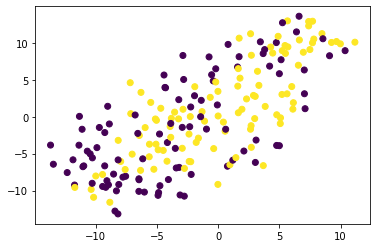

In [28]:
from sklearn import manifold
import matplotlib.pyplot as plt

tsne = manifold.TSNE(n_components=2, init='pca', random_state=42)
tsne_embd = tsne.fit_transform(embeddings)

plt.scatter(tsne_embd[:,0], tsne_embd[:,1], c=labels)
plt.show()

The cluster result is not really good due to the limited resources. Feel free to explore more on this topic in project with larger dataset.